## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)

sns.set(style="whitegrid")


## Load Dataset

In [2]:
BASE_PATH = "/content/drive/MyDrive/Deeplearning"  # sesuaikan kalau beda

train_df = pd.read_csv(f"{BASE_PATH}/train_transaction.csv")
test_df  = pd.read_csv(f"{BASE_PATH}/test_transaction.csv")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

train_df.head()


Train shape: (590540, 394)
Test  shape: (506691, 393)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Distribusi Target

Jumlah masing-masing kelas isFraud:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Proporsi masing-masing kelas isFraud:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


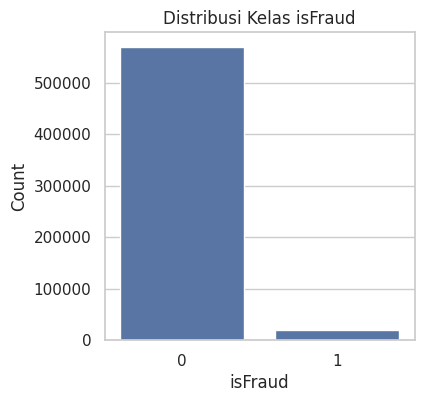

In [3]:
TARGET_COL = "isFraud"
ID_COL     = "TransactionID"

fraud_counts = train_df[TARGET_COL].value_counts()
fraud_ratio  = train_df[TARGET_COL].value_counts(normalize=True)

print("Jumlah masing-masing kelas isFraud:")
print(fraud_counts)
print("\nProporsi masing-masing kelas isFraud:")
print(fraud_ratio)

plt.figure(figsize=(4,4))
sns.countplot(x=TARGET_COL, data=train_df)
plt.title("Distribusi Kelas isFraud")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


Sampling

In [4]:
N_SAMPLE = 30_000

if len(train_df) > N_SAMPLE:
    train_sample = train_df.sample(
        n=N_SAMPLE,
        random_state=42
    ).reset_index(drop=True)
else:
    train_sample = train_df.copy()

print("Original train shape:", train_df.shape)
print("Sampled train shape :", train_sample.shape)

print(train_sample[TARGET_COL].value_counts())
print(train_sample[TARGET_COL].value_counts(normalize=True))


Original train shape: (590540, 394)
Sampled train shape : (30000, 394)
isFraud
0    28926
1     1074
Name: count, dtype: int64
isFraud
0    0.9642
1    0.0358
Name: proportion, dtype: float64


In [5]:
y = train_sample[TARGET_COL]
X = train_sample.drop(columns=[TARGET_COL, ID_COL])

test_ids = test_df[ID_COL]
X_test   = test_df.drop(columns=[ID_COL])

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Jumlah fitur numerik    :", len(numeric_features))
print("Jumlah fitur kategorikal:", len(categorical_features))


Jumlah fitur numerik    : 378
Jumlah fitur kategorikal: 14


Train-test split

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)


X_train: (24000, 392)
X_valid: (6000, 392)


Preprocessing (Imputer + Encoder)

In [7]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


## Random Forest

In [8]:
rf_clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced_subsample",  # handle class imbalance
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_clf)
])

print("Training Random Forest on sampled data...")
rf_pipeline.fit(X_train, y_train)
print("Training selesai.")


Training Random Forest on sampled data...
Training selesai.


# Evaluasi Random Forest

In [9]:
y_valid_proba_rf = rf_pipeline.predict_proba(X_valid)[:, 1]
y_valid_pred_rf  = (y_valid_proba_rf > 0.5).astype(int)

print("=== Random Forest (Sampled Data) ===")
print("ROC-AUC:", roc_auc_score(y_valid, y_valid_proba_rf))
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred_rf))


=== Random Forest (Sampled Data) ===
ROC-AUC: 0.8834322928182348

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5785
           1       0.89      0.19      0.31       215

    accuracy                           0.97      6000
   macro avg       0.93      0.59      0.65      6000
weighted avg       0.97      0.97      0.96      6000



In [10]:
# Ambil preprocessor & model dari pipeline yang sudah dilatih
preprocessor = rf_pipeline.named_steps["preprocessor"]
rf_model     = rf_pipeline.named_steps["model"]

batch_size = 30_000          # bisa dikecilkan jadi 30_000 kalau masih berat
all_proba  = []

n_test = len(X_test)
print("Total test rows:", n_test)

for start in range(0, n_test, batch_size):
    end = min(start + batch_size, n_test)
    print(f"Processing rows {start} to {end}...")

    X_batch = X_test.iloc[start:end]

    # transform batch
    X_batch_trans = preprocessor.transform(X_batch)

    # prediksi probabilitas fraud untuk batch ini
    proba_batch = rf_model.predict_proba(X_batch_trans)[:, 1]

    all_proba.extend(proba_batch)

len(all_proba)


Total test rows: 506691
Processing rows 0 to 30000...
Processing rows 30000 to 60000...
Processing rows 60000 to 90000...
Processing rows 90000 to 120000...
Processing rows 120000 to 150000...
Processing rows 150000 to 180000...
Processing rows 180000 to 210000...
Processing rows 210000 to 240000...
Processing rows 240000 to 270000...
Processing rows 270000 to 300000...
Processing rows 300000 to 330000...
Processing rows 330000 to 360000...
Processing rows 360000 to 390000...
Processing rows 390000 to 420000...
Processing rows 420000 to 450000...
Processing rows 450000 to 480000...
Processing rows 480000 to 506691...


506691

## ROC Curve & Precision–Recall Curve

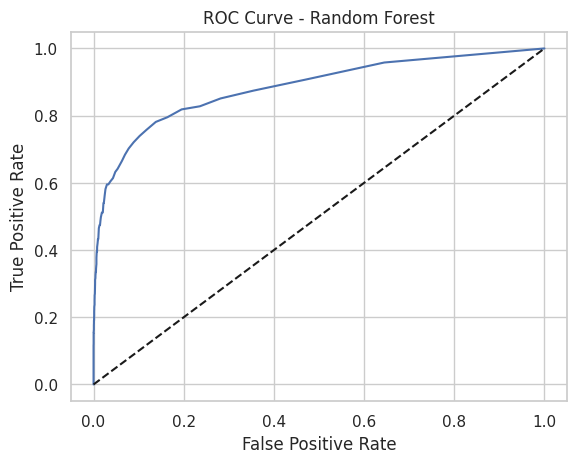

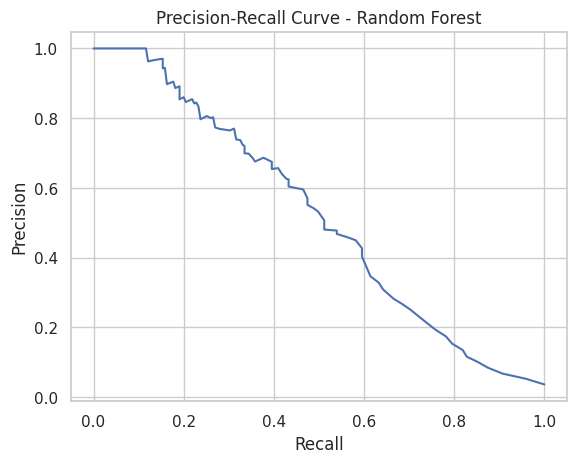

In [13]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_valid, y_valid_proba_rf)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.show()

prec, rec, _ = precision_recall_curve(y_valid, y_valid_proba_rf)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.show()


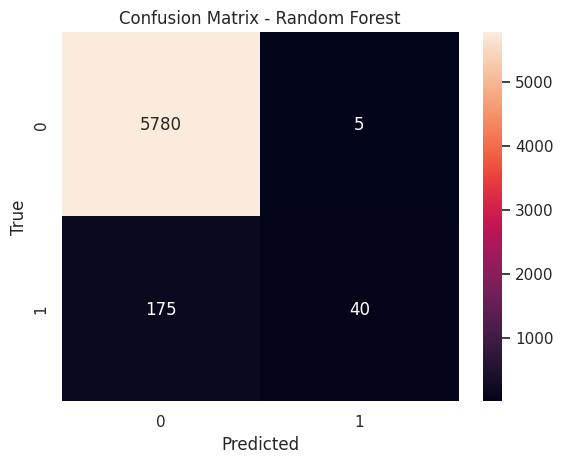

In [11]:
cm_rf = confusion_matrix(y_valid, y_valid_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Submission

In [12]:
submission = pd.DataFrame({
    "TransactionID": test_ids,
    "isFraud": all_proba
})

# Simpan langsung ke Google Drive biar aman
submission_path = "/content/drive/MyDrive/Deeplearning/submission_rf_batched.csv"
submission.to_csv(submission_path, index=False)

print("Submission disimpan sebagai:", submission_path)
submission.head()


Submission disimpan sebagai: /content/drive/MyDrive/Deeplearning/submission_rf_batched.csv


,TransactionID,isFraud
0,3663549,0.000000
1,3663550,0.000000
2,3663551,0.033333
3,3663552,0.013333
4,3663553,0.040000
